In [146]:
from keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

In [147]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data()

In [148]:
# Load the word index to decode the sequences back to text
word_index = reuters.get_word_index()

# Inverting the word index dictionary to decode indices back to words
index_to_word = {index: word for word, index in word_index.items()}

# Decoding function
def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i - 3, '?') for i in encoded_review])

# Decode the train and test data
train_texts = [decode_review(sequence) for sequence in train_data]
test_texts = [decode_review(sequence) for sequence in test_data]

# Create pandas DataFrames
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})

test_df = pd.DataFrame({
    'text': test_texts,
    
})

# Display the first few rows of the train DataFrame
print(train_df.head())

                                                text  label
0  ? mcgrath rentcorp said as a result of its dec...      3
1  ? generale de banque sa lt genb br and lt hell...      4
2  ? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlr...      3
3  ? the farmers home administration the u s agri...      4
4  ? seton co said its board has received a propo...      4


In [149]:
train_df

,text,label
0,? mcgrath rentcorp said as a result of its dec...,3
1,? generale de banque sa lt genb br and lt hell...,4
2,? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlr...,3
3,? the farmers home administration the u s agri...,4
4,? seton co said its board has received a propo...,4
...,...,...
8977,? finance minister kiichi miyazawa said japan ...,19
8978,? the price of gold bullion is likely to rise ...,19
8979,? international phoenix energy corp said it la...,25
8980,? shr loss 76 cts vs profit 50 cts net loss 19...,3


In [150]:
train_df['label'].nunique()

46

In [151]:
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def remove_stopwords_and_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

train_df['cleaned_text'] = train_df['text'].apply(remove_stopwords_and_punctuation)
test_df['cleaned_text'] = test_df['text'].apply(remove_stopwords_and_punctuation)



In [152]:
train_df['cleaned_text']

0       [mcgrath, rentcorp, said, result, december, ac...
1       [generale, de, banque, sa, lt, genb, br, lt, h...
2       [shr, 3, 28, dlrs, vs, 22, cts, shr, diluted, ...
3       [farmers, home, administration, u, agriculture...
4       [seton, co, said, board, received, proposal, c...
                              ...                        
8977    [finance, minister, kiichi, miyazawa, said, ja...
8978    [price, gold, bullion, likely, rise, second, h...
8979    [international, phoenix, energy, corp, said, l...
8980    [shr, loss, 76, cts, vs, profit, 50, cts, net,...
8981    [currency, fluctuations, may, reassert, influe...
Name: cleaned_text, Length: 8982, dtype: object

In [153]:
test_df['cleaned_text']

0       [great, atlantic, pacific, tea, co, said, thre...
1       [philippine, sugar, production, 1987, 88, crop...
2       [agriculture, departments, widening, louisiana...
3       [graham, mccormick, oil, gas, partnership, sai...
4       [strong, south, easterly, winds, keeping, many...
                              ...                        
2241    [lt, toronto, sun, publishing, corp, said, pla...
2242    [shr, loss, 45, cts, vs, profit, 20, cts, net,...
2243    [sept, 30, shr, 44, cts, net, 905, 000, vs, 63...
2244    [inland, vacuum, inc, said, board, proposed, t...
2245    [congress, give, u, agriculture, secretary, au...
Name: cleaned_text, Length: 2246, dtype: object

In [154]:
# ##skip gram
sentences = train_df['cleaned_text'].tolist()
sentences = test_df['cleaned_text'].tolist()

In [155]:
from gensim.models import Word2Vec
skipgram_model = Word2Vec(
    sentences=sentences,
    sg=1,
    vector_size=100,
    window=5,
    min_count=1,
)


In [156]:
skipgram_model.save("skipgram_model.model")

In [157]:

loaded_model = Word2Vec.load("skipgram_model.model")
loaded_model=loaded_model.wv

In [158]:
import numpy as np
def skip_embedding(words):
    embedding = [loaded_model[word] for word in words if word in loaded_model]
    return np.mean(embedding, axis=0)

embedding= train_df['cleaned_text'].apply(skip_embedding)  
embedding1 = test_df['cleaned_text'].apply(skip_embedding)


 
 
data=pd.DataFrame(embedding.tolist())
data1=pd.DataFrame(embedding1.tolist())


In [159]:
data.shape   ##train

(8982, 100)

In [160]:
data1.shape ##test

(2246, 100)

In [161]:
#to_categorical 
from keras.utils import to_categorical
train_labels = to_categorical(train_df['label'])
train_labels.shape


(8982, 46)

In [162]:
x = data
y = train_labels

In [163]:
#train val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [164]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import os
import tensorflow as tf

# Checkpoints -- Saves the best MOdel
model_name = "best1.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=2)

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout


model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),  # Input layer
    Dense(64, activation='relu'),                            # Hidden layer 1
    Dropout(0.1),                                            # Dropout layer 
    Dense(16, activation='relu'),   
    Dense(46, activation='softmax')                           # Output layer
])

c:\Users\rodea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
epochs = 200
# Learning Rate Scheduler -- Change Learning Rate after 70% of epochs
def learning_rate(epoch, lr):
    if epoch < 0.7 * epochs:
        return lr
    else:
        return float(lr * tf.math.exp(-0.009))

lr_scheduler = LearningRateScheduler(learning_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=132, validation_data= (X_val, y_val), callbacks = [lr_scheduler,checkpoint ])

Epoch 1/200
48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1821 - loss: 3.5262 
Epoch 1: val_loss improved from inf to 2.15792, saving model to best1.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2038 - loss: 3.4609 - val_accuracy: 0.5081 - val_loss: 2.1579 - learning_rate: 0.0010
Epoch 2/200
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4925 - loss: 2.1069
Epoch 2: val_loss improved from 2.15792 to 1.73166, saving model to best1.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4943 - loss: 2.0900 - val_accuracy: 0.5754 - val_loss: 1.7317 - learning_rate: 0.0010
Epoch 3/200
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5613 - loss: 1.7774
Epoch 3: val_loss improved from 1.73166 to 1.64044, saving model to best1.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5649 - loss: 1.7668 - val_accuracy: 0.5943 - val_loss: 1.6404 - learning_rate: 0.0010
Epoch 4/200
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5995 - loss: 1.6627
Epoch

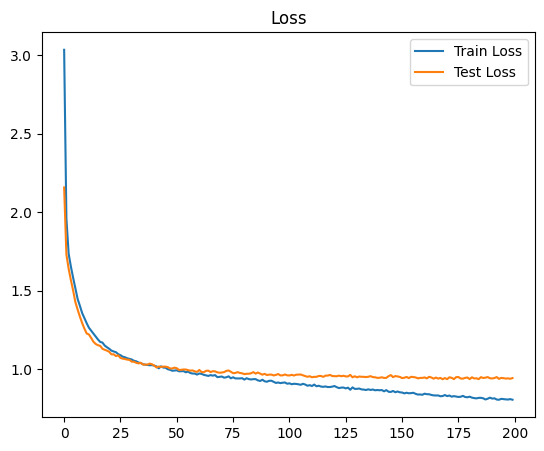

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

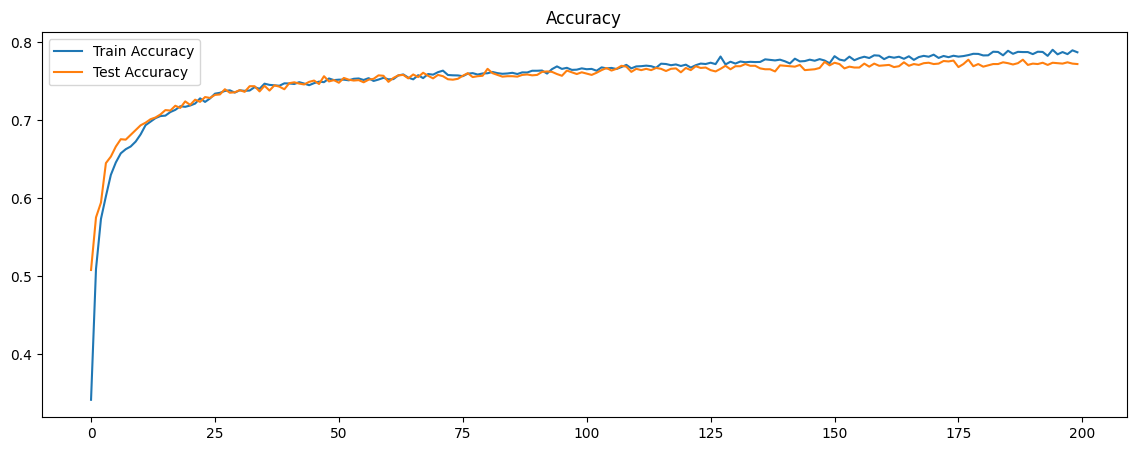

In [168]:
plt.figure(figsize=(14, 5))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

2246